In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error


### Load data 

In [2]:
users_df = pd.read_csv('movie/users.dat', sep='::', engine='python', header=None, names=['userID', 'gender', 'age', 'occupation', 'zip_code'])
users_df

,userID,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [3]:
movies_df = pd.read_csv('movie/movies.dat', sep='::', engine='python', header=None, names=["movieID", "title", "genres"])

movies_df

,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [4]:
ratings_df = pd.read_csv('movie/ratings.dat', sep='::', engine="python",header=None, names=['userID','movieID','rating','Timestamp'])
ratings_df

,userID,movieID,rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### EDA

In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userID      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip_code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [6]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieID  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userID     1000209 non-null  int64
 1   movieID    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


Text(0, 0.5, 'Count')

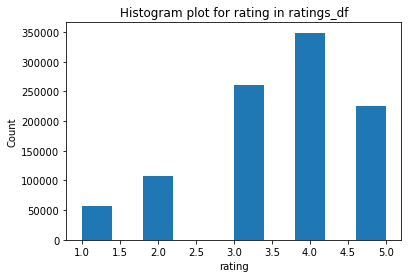

In [8]:
plt.hist(ratings_df['rating'])
plt.title('Histogram plot for rating in ratings_df')
plt.xlabel('rating')
plt.ylabel('Count')

In [9]:
ratings_df['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

#### check missing value

In [10]:
users_df.isnull().sum()

userID        0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

In [11]:
movies_df.isnull().sum()

movieID    0
title      0
genres     0
dtype: int64

In [12]:
ratings_df.isnull().sum()

userID       0
movieID      0
rating       0
Timestamp    0
dtype: int64

In [13]:
# shuffle the ratings_df and split into train_df and test_df

train_df = shuffle(ratings_df).iloc[:700146]
test_df = shuffle(ratings_df).iloc[700146:]

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [14]:
train_df

,userID,movieID,rating,Timestamp
0,2565,2240,4,973970865
1,3163,2135,5,968883468
2,1268,3421,4,974817361
3,1322,1187,4,974787814
4,4908,1371,2,962685071
...,...,...,...,...
700141,131,551,4,977433797
700142,1297,372,4,974790071
700143,4696,3617,3,963597176
700144,3690,555,4,966308566


In [15]:
test_df

,userID,movieID,rating,Timestamp
0,1699,1204,5,981321634
1,4169,2351,5,965692994
2,1425,3260,4,976931617
3,3940,1730,2,965752524
4,3842,1104,5,978172779
...,...,...,...,...
300058,5787,3032,4,958110109
300059,678,1191,4,989242228
300060,4623,2707,5,964218906
300061,2819,3324,2,972659920


In [16]:
# create the rating matrix 
movieidx, _ = pd.factorize(train_df['movieID'])
useridx, _ = pd.factorize(train_df['userID'])

rating_matrix = coo_matrix((train_df['rating'], (useridx, movieidx))).toarray()

### Train the data with Non-negative matrix factorization from SKlearn

In [17]:
nmf_model = NMF(n_components=5, random_state=42).fit(rating_matrix)

train_w = nmf_model.transform(rating_matrix)


### Predict the movie ratings

In [18]:
test_preds = []

movieidx_test, _ = pd.factorize(test_df['movieID'])
useridx_test, _ = pd.factorize(test_df['userID'])

for _, row in test_df.iterrows():
    user_test = row['userID']
    movie_test = row['movieID']
    test_preds.append(rating_matrix[useridx_test[user_test], movieidx_test[movie_test]])

    

### Calculate the  Root Mean Squared Error (RMSE) Score

What is the RMSE?

RMSE calculate the average size of the errors between actual and predicted movie ratings. Therefore, The lower the RMSE score, the better the model performed.


In [19]:

rmse = np.sqrt(mean_squared_error(test_df.rating, test_preds))

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 3.5824997970680807


## Questions:

### Discuss the results and why sklearn's non-negative matrix facorization library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it?



Non-negative matrix facorization is curse of dimensionality. The dataset is high dimensional and sparse. That result non-negative matrix facorization method with low perform. 

To imporve the result and continue use NMF model, we could reduce the dimensionality of the dataset using methods like PCA, feature engineering. or using triplet to help with sparse matrix. 

## Reference:

1. Week3 : recommender-system

2. Root Mean square Error (RMSE) in AI: What you need to know. (2024, April 8). Arize AI. https://arize.com/blog-course/root-mean-square-error-rmse-what-you-need-to-know/